In [11]:
# Preamble: minimal imports + local include
using Random
using Statistics
using Printf
using Plots
using Logging

include("formatting.jl")

if !isdefined(Main, :System1D)
    include("../src/System1D.jl")
end
using .System1D: Hamiltonian, TrialWF, Walker, VMCParams, VMCSim, run_vmc!, plot_snapshot_1d_density


## System: 1D Harmonic Oscillator (VMC)

**Potential**
$$ V(x) = \frac{1}{2} x^2 $$

**Trial wavefunction (Gaussian)**
$$ \psi_T(x) = e^{-\alpha x^2 / 2} $$

This cell defines the Hamiltonian and trial wavefunction, initializes walkers, and runs VMC.


In [12]:
# System: 1D harmonic oscillator (VMC)
V(R) = 0.5 * R[1]^2
H = Hamiltonian(1, 0.5, V)

alpha = 1.0
logpsi(R) = -0.5 * alpha * R[1]^2
gradlogpsi(R) = [-alpha * R[1]]
lapllogpsi(R) = -alpha

trial = TrialWF(logpsi, gradlogpsi, lapllogpsi)

# Walkers and params
targetN = 5000
walkers = [Walker([randn()]) for _ in 1:targetN]

params = VMCParams(0.5, 500, targetN, 0.5)

# Run
rng_sim = MersenneTwister(42)
sim = VMCSim(H, params, walkers, trial, rng_sim)
run_vmc!(sim; snapshot_steps=[params.nsteps])

energy_history = sim.energy_history
energy_variance_history = sim.energy_variance_history

nothing


## Results

**Exact ground-state energy**
$$ E_0 = \frac{1}{2} \; \text{(a.u.)} $$

This cell reports the post-equilibration energy and plots the VMC energy and local-energy variance over time, plus the final walker density.


HO VMC energy (post-eq, nequil=100): E = 0.500000 +/- 0.000000
Final step: E = 0.50, Var(E_L) = 0.00
Reference energy: 0.50
Final acceptance rate: 0.9207


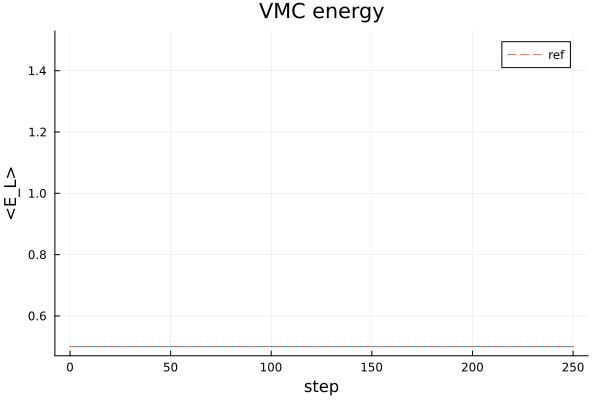

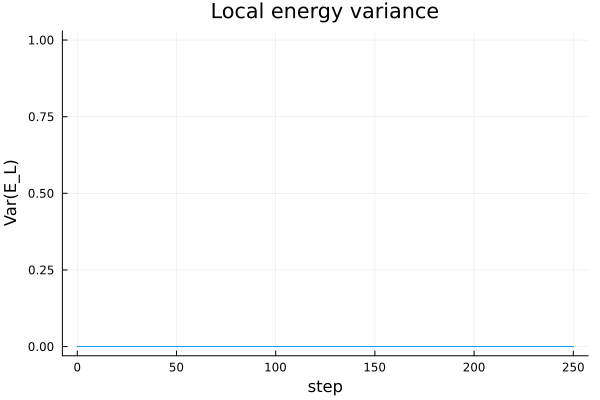

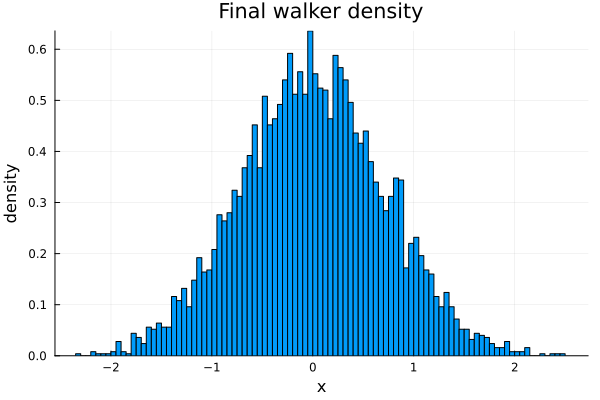

In [13]:
# Results and plots
t = (0:params.nsteps) .* params.dt
E_ref = 0.5

nequil = Int(round(0.2 * params.nsteps))
start_idx = min(nequil + 1, length(energy_history))
postE = energy_history[start_idx:end]

Ebar = mean(postE)
SEM = (length(postE) > 1) ? std(postE) / sqrt(length(postE)) : NaN

Ebar_str, SEM_str = format_with_uncertainty(Ebar, SEM)
println("HO VMC energy (post-eq, nequil=$(nequil)): E = $(Ebar_str) +/- $(SEM_str)")
E_final_str, var_str = format_pair_sigfig(energy_history[end], energy_variance_history[end]; sigfigs=2)
println("Final step: E = $(E_final_str), Var(E_L) = $(var_str)")
println("Reference energy: $(format_sigfig(E_ref; sigfigs=2))")
println(@sprintf("Final acceptance rate: %.4f", sim.acceptance_rate))


Logging.with_logger(Logging.NullLogger()) do
    redirect_stderr(devnull) do
        p1 = plot(t, energy_history, xlabel="step", ylabel="<E_L>", title="VMC energy", label=false)
        plot!(p1, [t[1], t[end]], [E_ref, E_ref], ls=:dash, label="ref")
        display(p1)
        
        p2 = plot(t, energy_variance_history, xlabel="step", ylabel="Var(E_L)", title="Local energy variance", label=false)
        display(p2)
        
        if !isempty(sim.walker_positions_history)
            snap = sim.walker_positions_history[end]
            p3 = plot_snapshot_1d_density(snap; nbins=120, title="Final walker density")
            display(p3)
        end
    end
end
